To begin copy this notebook to your own drive:

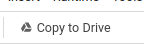


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [2]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:14<00:00, 32.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:02<00:00, 3.63MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 104.7 MB/s eta 0:0

In [4]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [6]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [8]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-8-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [9]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [13]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, drop_rate=0):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          #prob_zero = drop_rate
          #mask = torch.bernoulli(torch.full(self.embeddings.weight.data.shape, prob_zero).float())
          #self.embeddings.weight.data = self.embeddings.weight.data * mask

          glove_embeddings = np.load("glove.npy")
          embedding_dim = glove_embeddings.shape[1]

          #self.classifier = nn.Linear(embedding_dim, self.num_labels)
          #hidden_size = 128
          self.classifier = nn.Sequential(
              nn.Dropout(p=drop_rate),
              #nn.Linear(embedding_dim, embedding_dim),
              #nn.Linear(embedding_dim, embedding_dim),
              #nn.ReLU(),
              nn.Linear(embedding_dim, embedding_dim),
              #nn.ReLU(),
              nn.Linear(embedding_dim, self.num_labels),
              #nn.ReLU(),
              nn.Softmax(dim=1)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      #masked_embeddings = embeddings * attention_masks.unsqueeze(-1)
      #avg = torch.mean(masked_embeddings, dim=1)
      avg = torch.mean(embeddings, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [11]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=10 , #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-3 ,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6127, 'learning_rate': 0.0009893367455747495, 'epoch': 0.32}
{'loss': 0.5248, 'learning_rate': 0.000978673491149499, 'epoch': 0.64}
{'loss': 0.5136, 'learning_rate': 0.0009680102367242482, 'epoch': 0.96}
{'eval_loss': 0.5097435116767883, 'eval_accuracy': 0.79696, 'eval_runtime': 10.9691, 'eval_samples_per_second': 2279.134, 'eval_steps_per_second': 142.491, 'epoch': 1.0}
{'loss': 0.5042, 'learning_rate': 0.0009573469822989977, 'epoch': 1.28}
{'loss': 0.4912, 'learning_rate': 0.0009466837278737471, 'epoch': 1.6}
{'loss': 0.4946, 'learning_rate': 0.0009360204734484965, 'epoch': 1.92}
{'eval_loss': 0.5245146751403809, 'eval_accuracy': 0.7754, 'eval_runtime': 13.6156, 'eval_samples_per_second': 1836.126, 'eval_steps_per_second': 114.795, 'epoch': 2.0}
{'loss': 0.4897, 'learning_rate': 0.0009253572190232459, 'epoch': 2.24}
{'loss': 0.4803, 'learning_rate': 0.0009146939645979954, 'epoch': 2.56}
{'loss': 0.4891, 'learning_rate': 0.0009040307101727447, 'epoch': 2.88}
{'eval_loss': 0

TrainOutput(global_step=46890, training_loss=0.47473373950023495, metrics={'train_runtime': 985.659, 'train_samples_per_second': 760.912, 'train_steps_per_second': 47.572, 'train_loss': 0.47473373950023495, 'epoch': 30.0})

In [1]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
x = []
y = []
for log in log_history:
  if 'eval_accuracy' in log:
    x.append(log['epoch'])
    y.append(log['eval_accuracy'])
acc_drop_0 = max(y)
plt.plot(x, y)
plt.ylabel('eval_accuracy')
plt.xlabel('epochs')
plt.show()


NameError: ignored

In [14]:
acc_drop = [0.83256]
abc = []
for i in range(1, 6):
  model = DAN(i*0.1)

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE

                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  log_history = trainer.state.log_history
  y = []
  for log in log_history:
    if 'eval_accuracy' in log:
      y.append(log['eval_accuracy'])
  print(y)
  abc.append(y)
  acc_drop.append(max(y))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.528100,0.506985,0.803880
2,0.515400,0.500708,0.807040
3,0.521400,0.490682,0.815360
4,0.509900,0.498102,0.804960
5,0.507100,0.485961,0.820320
6,0.510300,0.493627,0.811160
7,0.511000,0.492355,0.813360
8,0.501200,0.486267,0.820400
9,0.499600,0.487916,0.817080
10,0.498800,0.486255,0.820200


[0.80388, 0.80704, 0.81536, 0.80496, 0.82032, 0.81116, 0.81336, 0.8204, 0.81708, 0.8202]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.546800,0.525938,0.779280
2,0.536800,0.510146,0.793080
3,0.537800,0.524441,0.778240
4,0.535900,0.501468,0.801800
5,0.530100,0.496111,0.809840
6,0.524600,0.519079,0.784000
7,0.527000,0.500131,0.805880
8,0.519200,0.495831,0.809920
9,0.519400,0.493745,0.811440
10,0.516700,0.494269,0.811720


[0.77928, 0.79308, 0.77824, 0.8018, 0.80984, 0.784, 0.80588, 0.80992, 0.81144, 0.81172]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.560600,0.525204,0.785280
2,0.550100,0.511524,0.795120
3,0.552900,0.531540,0.769920
4,0.553700,0.514295,0.787800
5,0.544100,0.505890,0.800600
6,0.546400,0.504757,0.802040
7,0.550600,0.515279,0.788760
8,0.539800,0.504800,0.801200
9,0.536700,0.502026,0.804400
10,0.535300,0.502675,0.803840


[0.78528, 0.79512, 0.76992, 0.7878, 0.8006, 0.80204, 0.78876, 0.8012, 0.8044, 0.80384]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.578200,0.549083,0.755080
2,0.567700,0.544246,0.754280
3,0.572500,0.574643,0.721600
4,0.569000,0.516761,0.789840
5,0.560100,0.513349,0.793920
6,0.562300,0.519163,0.787720
7,0.560700,0.517295,0.788880
8,0.554600,0.513419,0.793120
9,0.555300,0.511926,0.794600
10,0.550400,0.511722,0.795000


[0.75508, 0.75428, 0.7216, 0.78984, 0.79392, 0.78772, 0.78888, 0.79312, 0.7946, 0.795]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.593900,0.551438,0.757920
2,0.585100,0.539869,0.764280
3,0.586700,0.571682,0.724240
4,0.584000,0.526017,0.781760
5,0.580800,0.528472,0.779960
6,0.578300,0.526710,0.781520
7,0.575200,0.529412,0.776800
8,0.567500,0.524022,0.783160
9,0.572300,0.524303,0.783400
10,0.571600,0.523332,0.784640


[0.75792, 0.76428, 0.72424, 0.78176, 0.77996, 0.78152, 0.7768, 0.78316, 0.7834, 0.78464]


[0.83256, 0.8204, 0.81172, 0.8044, 0.795, 0.78464]


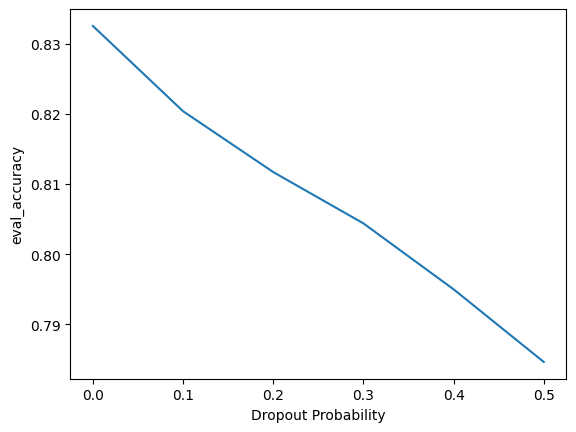

In [15]:
print(acc_drop)
plt.plot([0, 0.1, 0.2, 0.3, 0.4, 0.5],acc_drop)
plt.ylabel('eval_accuracy')
plt.xlabel('Dropout Probability')
plt.show()

In [19]:
acc_per_model = []

In [40]:
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, drop_rate=0):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE

          glove_embeddings = np.load("glove.npy")
          embedding_dim = glove_embeddings.shape[1]

          #self.classifier = nn.Linear(embedding_dim, self.num_labels)
          #hidden_size = 128
          self.classifier = nn.Sequential(
              nn.Linear(embedding_dim, embedding_dim),
              nn.ReLU(),
              nn.Linear(embedding_dim, embedding_dim),
              nn.ReLU(),
              nn.Linear(embedding_dim, embedding_dim),
              nn.ReLU(),
              nn.Linear(embedding_dim, self.num_labels),
              nn.Softmax(dim=1)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      avg = torch.mean(embeddings, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [41]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=10 , #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-3 ,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [42]:
trainer.train()
log_history = trainer.state.log_history
y = []
for log in log_history:
  if 'eval_accuracy' in log:
    y.append(log['eval_accuracy'])
acc_per_model.append(max(y))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5968, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.5104, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5214, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.4986072778701782, 'eval_accuracy': 0.80544, 'eval_runtime': 11.4616, 'eval_samples_per_second': 2181.193, 'eval_steps_per_second': 136.368, 'epoch': 1.0}
{'loss': 0.5127, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5006, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.4972, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.5135106444358826, 'eval_accuracy': 0.78896, 'eval_runtime': 11.3881, 'eval_samples_per_second': 2195.276, 'eval_steps_per_second': 137.249, 'epoch': 2.0}
{'loss': 0.4927, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.4826, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.4935, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 

[0.83256, 0.8302, 0.83224, 0.83304]
[0.80544, 0.78896, 0.81644, 0.8286, 0.79032, 0.82652, 0.82712, 0.8286, 0.8292, 0.83304]


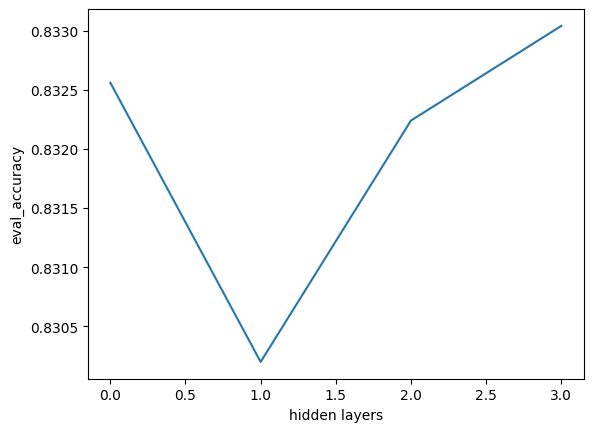

In [43]:
print(acc_per_model)
print(y)
plt.plot(acc_per_model)
plt.ylabel('eval_accuracy')
plt.xlabel('hidden layers')
plt.show()

In [61]:
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, drop_rate=0):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE

          glove_embeddings = np.load("glove.npy")
          embedding_dim = glove_embeddings.shape[1]

          #self.classifier = nn.Linear(embedding_dim, self.num_labels)
          #hidden_size = 128
          self.classifier = nn.Sequential(
              nn.Linear(embedding_dim, embedding_dim),
              nn.Tanh(),
              nn.Linear(embedding_dim, embedding_dim),
              nn.Tanh(),
              nn.Linear(embedding_dim, self.num_labels),
              nn.Softmax(dim=1)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      avg = torch.mean(embeddings, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [62]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=10 , #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-3 ,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [63]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5858, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.5172, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5149, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.4990748167037964, 'eval_accuracy': 0.80428, 'eval_runtime': 10.2015, 'eval_samples_per_second': 2450.617, 'eval_steps_per_second': 153.213, 'epoch': 1.0}
{'loss': 0.5049, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.5057, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.4878755509853363, 'eval_accuracy': 0.81612, 'eval_runtime': 11.5263, 'eval_samples_per_second': 2168.952, 'eval_steps_per_second': 135.603, 'epoch': 2.0}
{'loss': 0.4944, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.4911, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.4915, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 0.4

TrainOutput(global_step=15630, training_loss=0.4865696160822287, metrics={'train_runtime': 315.2038, 'train_samples_per_second': 793.138, 'train_steps_per_second': 49.587, 'train_loss': 0.4865696160822287, 'epoch': 10.0})

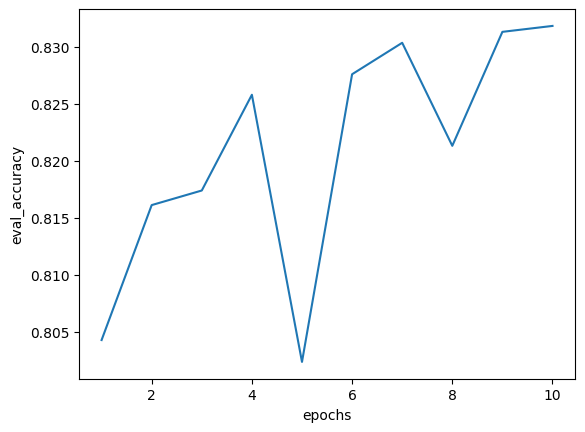

In [64]:
log_history = trainer.state.log_history
x = []
y = []
for log in log_history:
  if 'eval_accuracy' in log:
    x.append(log['epoch'])
    y.append(log['eval_accuracy'])
plt.plot(x, y)
plt.ylabel('eval_accuracy')
plt.xlabel('epochs')
plt.show()